<a href="https://colab.research.google.com/github/DanielMaschmann/PHANGS_HST_star_cluster/blob/main/accessing_phangs_hst_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jupyter notebook to access and visualize star clusters and compact associations in nearby galaxies.

The data release is presented here:
https://archive.stsci.edu/hlsp/phangs/phangs-cat
and the accompanying paper is [Maschmann et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240304901M/abstract).

We designed this Jupyter notebook in a way that the code should also work in normal python scripts.

For feedback and questions contact daniel.maschmann(at)rwth-aachen.de


In [6]:
# packages needed to for file management,
# downloading and unpacking compressed catalogs.
import os
from urllib3 import PoolManager
import tarfile
import zipfile

# basic packages for data handling and plotting
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

from scipy.constants import c as speed_of_light

# we download a file with multiple helpfull methods from the same git repository.
# These functions are well documented to facilitate further reading.
helper_func_url = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/helper_func.py'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', helper_func_url, preload_content=False)
with open('helper_func.py', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)

!pip install dust_extinction

# in case of updates
%load_ext autoreload
%autoreload 2
import importlib
import helper_func
mylibrary = importlib.reload(helper_func)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In this Jupyter Notebook we will demonstrate to access and handle the cluster catalog for the Galaxy NGC 1566

In [7]:
# we use NGC ngc1097 as an example
galaxy_name = 'ngc1097'


Download the cluster and compact associataion catalogs and extract them.
The catalog data release is described here https://archive.stsci.edu/hlsp/phangs/phangs-cat and the list of the data products can be found here: https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table \

In [8]:
# get the file name and the URL for the catalogs
url_path_structure = 'https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/'
catalog_file_name_compressed = ('hlsp_phangs-cat_hst_acs-uvis_%s_multi_v1_cats.tar.gz' %
                    galaxy_name)
url = url_path_structure + catalog_file_name_compressed
# Download compressed catalogs. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(catalog_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + catalog_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

In [9]:
# some galaxies have HST image mosaics. Therefore the file names can change!
mosaic_flag = True
if mosaic_flag:
  bundle_file_name = galaxy_name + 'mosaic'
else:
  bundle_file_name = galaxy_name

In [10]:
img_file_name_compressed = 'hlsp_phangs-hst_hst_wfc3-uvis_%s_multi_v1_drc-bundle.tar.gz' % bundle_file_name
url = 'https://archive.stsci.edu/hlsps/phangs-hst/' + bundle_file_name + '/' + img_file_name_compressed
# Download compressed image bundle. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(img_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + img_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

Now we will access the cluster catalog for human class 1 and 2 and the catalog for compact associations (class 3)


In [11]:
# open cluster and association catalogs
cat_hum_cl12_table = Table.read('catalogs/hlsp_phangs-cat_hst_uvis_%s_multi_v1_obs-human-cluster-class12.fits' % galaxy_name)
cat_hum_cl3_table = Table.read('catalogs/hlsp_phangs-cat_hst_uvis_%s_multi_v1_obs-human-compact-association-class3.fits' % galaxy_name)
# inspect the content
cat_hum_cl12_table



INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA,PHANGS_F275W_VEGA_ERR,PHANGS_F336W_VEGA,PHANGS_F336W_VEGA_ERR,PHANGS_F438W_VEGA,PHANGS_F438W_VEGA_ERR,PHANGS_F555W_VEGA,PHANGS_F555W_VEGA_ERR,PHANGS_F814W_VEGA,PHANGS_F814W_VEGA_ERR,PHANGS_F275W_mJy,PHANGS_F275W_mJy_ERR,PHANGS_F336W_mJy,PHANGS_F336W_mJy_ERR,PHANGS_F438W_mJy,PHANGS_F438W_mJy_ERR,PHANGS_F555W_mJy,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy,PHANGS_F814W_mJy_TOT_ERR,PHANGS_NON_DETECTION_FLAG,PHANGS_NO_COVERAGE_FLAG,PHANGS_CI,CC_CLASS
,,,,,,deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,
int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7
1,19,38,5602,4801.12,2219.94,41.59823102243026,-30.3195777525278,1.0,1,1.0,24.250606349350278,0.3413120759351707,23.56861827435267,0.1209868543134049,23.386919346729748,0.042899395332845466,23.155811626493623,0.012896790607968027,22.365585347245382,0.03394132106969569,0.00018045023844164796,5.678303185715089e-05,0.0004649783052651588,5.18657112917148e-05,0.0018668621959467356,7.383680482785158e-05,0.0020670707873439555,2.45779955330274e-05,0.0027782150594729198,8.693688316747242e-05,0.0,0.0,1.6270172392139897,outside
2,28,59,1211,5385.52,2284.88,41.59078023253215,-30.318863706825663,2.0,2,1.0,19.734525126715678,0.011606177201930124,20.237366559831845,0.012158179130513536,21.794390020727164,0.01695339349086986,21.889387773697358,0.008884845604824705,21.365672993013984,0.01778401380388086,0.011555532126326921,0.00012364843080989673,0.009998466044919253,0.00011207567847029266,0.008093269302180572,0.00012649987510941855,0.006636282886408602,5.436059963969714e-05,0.0069779973919709744,0.00011441159825145036,0.0,0.0,1.4830057955500273,outside
3,39,79,4435,5328.34,2323.84,41.591509198913045,-30.31843488517973,2.0,2,1.0,21.661275909744955,0.038175840855029675,22.095808259883785,0.041994131629712945,23.042241454335773,0.03831289211007517,22.94695934373735,0.012095167737100511,22.37105904046626,0.03998526376016067,0.0019592490104922305,6.895848482692249e-05,0.001805330403067705,6.989639292138896e-05,0.0025643861241957107,9.058114742653221e-05,0.0025055107042142536,2.7939435097588226e-05,0.0027642440522990044,0.00010190272831215635,0.0,0.0,1.4386241043210957,map
4,64,117,4479,4541.11,2447.51,41.601545511721106,-30.3170727926211,1.0,1,0.7,21.12664384275856,0.026946391884062136,21.53617376633271,0.025822758441782646,23.19450229432209,0.0400343067753295,23.129610658250865,0.014743003819752932,22.888644579930855,0.056073477021617864,0.0032058445730115902,7.964390528874356e-05,0.0030228075165352835,7.196520866677722e-05,0.0022288409701273887,8.226609029341112e-05,0.0021175600585413316,2.8782676573456456e-05,0.0017160983274088634,8.871746374060536e-05,0.0,0.0,1.4496939932951458,outside
5,91,163,7919,5634.33,2604.53,41.58760791740105,-30.315345933233623,1.0,1,1.0,24.61748244709537,0.5047613422272171,24.25666529536384,0.22803255320224858,24.038466806540264,0.07408008074313105,23.31737130087364,0.015344849771806559,22.197399690065986,0.030873032154460748,0.00012870843841500566,5.989665516184621e-05,0.00024672541142746436,5.187047136987272e-05,0.0010244559222291174,6.996876160188978e-05,0.0017812770793968766,2.5200176554420863e-05,0.0032436958410226027,9.232703144239532e-05,0.0,0.0,1.8568970390834667,ogcc
6,111,190,4751,5486.67,2669.47,41.58949036084037,-30.314631152633172,1.0,1,1.0,22.459879371366835,0.07271094266086384,22.657314258458374,0.05887791800204035,23.133120651558738,0.037937620735567966,23.070144451099512,0.012064258904521735,22.51946763675011,0.041358935482331376,0.0009389625077018889,6.294445671182412e-05,0.00107635193677333

In [12]:
# get all data we need for the following examples
# coordinates
ra_hum_cl12, dec_hum_cl12 = cat_hum_cl12_table['PHANGS_RA'], cat_hum_cl12_table['PHANGS_DEC']
ra_hum_cl3, dec_hum_cl3 = cat_hum_cl3_table['PHANGS_RA'], cat_hum_cl3_table['PHANGS_DEC']
# morphological classification
class_human_hum_cl12 = cat_hum_cl12_table['PHANGS_CLUSTER_CLASS_HUMAN']
class_human_hum_cl3 = cat_hum_cl3_table['PHANGS_CLUSTER_CLASS_HUMAN']
# v-band flux
v_band_flux_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_mJy']
v_band_flux_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_mJy']
# v-band mag
v_band_mag_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_VEGA']
v_band_mag_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_VEGA']
# color
color_u_b_hum_cl12 = cat_hum_cl12_table['PHANGS_F336W_VEGA'] - cat_hum_cl12_table['PHANGS_F438W_VEGA']
color_v_i_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_VEGA'] - cat_hum_cl12_table['PHANGS_F814W_VEGA']
color_u_b_hum_cl3 = cat_hum_cl3_table['PHANGS_F336W_VEGA'] - cat_hum_cl3_table['PHANGS_F438W_VEGA']
color_v_i_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_VEGA'] - cat_hum_cl3_table['PHANGS_F814W_VEGA']
# color-color classification
color_color_class_hum_cl12 = cat_hum_cl12_table['CC_CLASS']
color_color_class_hum_cl3 = cat_hum_cl3_table['CC_CLASS']

In order to visualize the location of the clusters we have to access the image data. As an example we use here the V-band (F555W).

In [13]:
# load the downloaded images
v_band_img_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_exp-drc-sci.fits' % (bundle_file_name, bundle_file_name))
v_band_img_header = v_band_img_hdu[0].header
v_band_img_data = v_band_img_hdu[0].data
v_band_img_wcs = WCS(v_band_img_header)

# change the image data from electron counts to units of Jy
# wavelength in angstrom
pivot_wavelength = v_band_img_header['PHOTPLAM']
# inverse sensitivity, ergs/cm2/Ang/electron
sensitivity = v_band_img_header['PHOTFLAM']
# speed of light in Angstrom/s
c = speed_of_light * 1e10
# change the conversion facto to get erg s−1 cm−2 Hz−1
f_nu = sensitivity * pivot_wavelength ** 2 / c
# change to get Jy
conversion_factor = f_nu * 1e23
# apply the conversion factor to the data
v_band_img_data *= conversion_factor

# this is not used in this tutorial but for completeness here we will load the uncertainty maps
v_band_invers_var_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_err-drc-wht.fits' % (bundle_file_name, bundle_file_name))
v_band_invers_var_data = v_band_invers_var_hdu[0].data
# the uncertainties are stored as inverse variance so we need to convert them into the standard deviation.
v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)
# and again we need to apply the conversion factor to these data
v_band_err_data *= conversion_factor





C:\Users\SEANM\AppData\Local\Temp\ipykernel_13444\2281417409.py:25: RuntimeWarning: divide by zero encountered in divide
  v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)


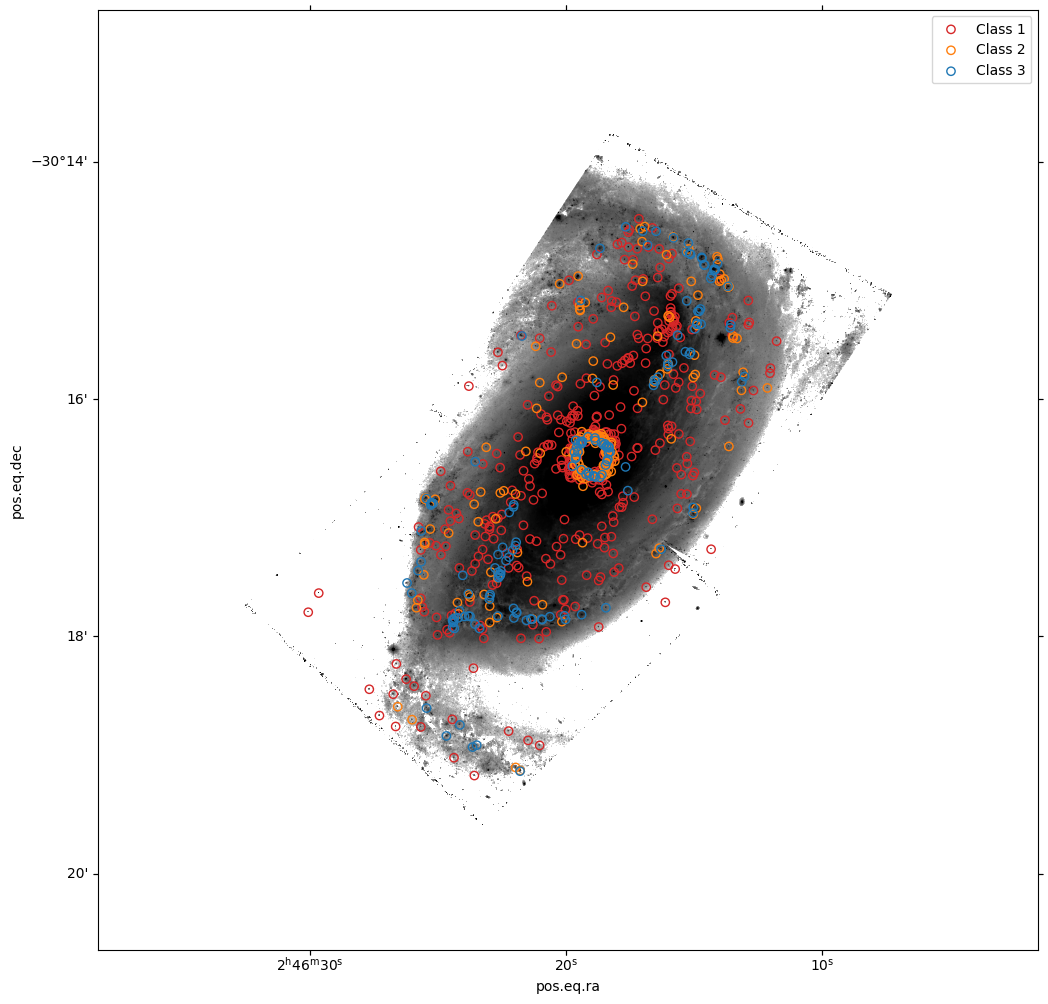

In [14]:
# in order to visualize the image we calculate some states of the image and calculate a strech.
mean, median, std = sigma_clipped_stats(v_band_img_data, sigma=3.0)
norm = LogNorm(0.1*std, median + 100*std)
figure = plt.figure(figsize=(10, 10))
ax_img = figure.add_axes([0.05, 0.05 , 0.94, 0.94], projection=v_band_img_wcs)
ax_img.imshow(v_band_img_data, cmap='Greys', norm=norm)

coords_hum_cl12 = SkyCoord(ra=ra_hum_cl12, dec=dec_hum_cl12)
coords_hum_cl12_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl12)

coords_hum_cl3 = SkyCoord(ra=ra_hum_cl3, dec=dec_hum_cl3)
coords_hum_cl3_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl3)

ax_img.scatter(coords_hum_cl12_pix[0][class_human_hum_cl12==1],
               coords_hum_cl12_pix[1][class_human_hum_cl12==1],
               facecolor='None', edgecolor='tab:red', linewidth=1,
               label='Class 1')
ax_img.scatter(coords_hum_cl12_pix[0][class_human_hum_cl12==2],
               coords_hum_cl12_pix[1][class_human_hum_cl12==2],
               facecolor='None', edgecolor='tab:orange', linewidth=1,
               label='Class 2')
ax_img.scatter(coords_hum_cl3_pix[0], coords_hum_cl3_pix[1], facecolor='None',
               edgecolor='tab:blue', linewidth=1, label='Class 3')

ax_img.legend()

In [15]:
# cutout of random class 1, 2, 3 clusters
mask_class1 = class_human_hum_cl12 == 1
mask_class2 = class_human_hum_cl12 == 2

coord_bright_class1 = coords_hum_cl12[mask_class1][101]
coord_bright_class2 = coords_hum_cl12[mask_class2][13]
coord_bright_class3 = coords_hum_cl3[4]

cutout_bright_class1 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class1,
                                                  cutout_size=(2, 2))
cutout_bright_class2 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class2,
                                                  cutout_size=(2, 2))
cutout_bright_class3 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class3,
                                                  cutout_size=(2, 2))

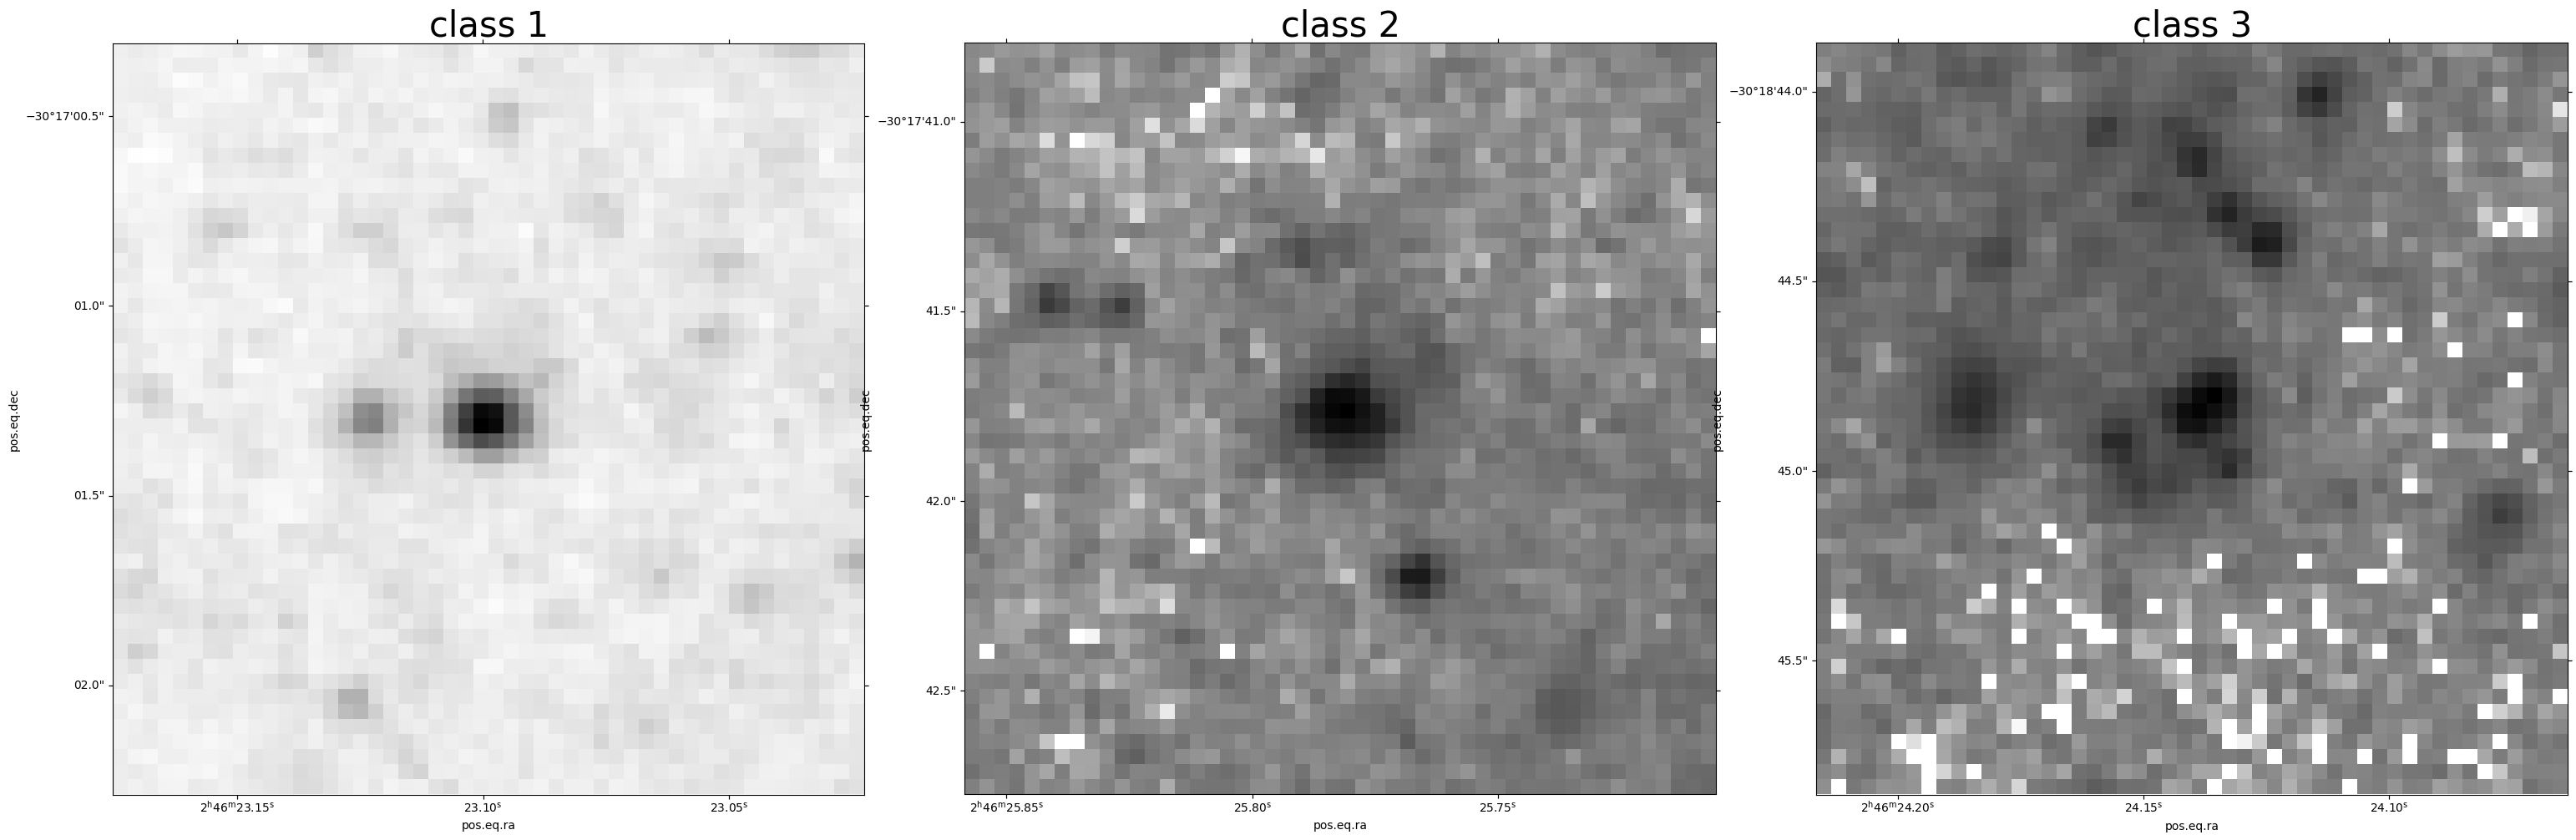

In [16]:
figure_cutouts = plt.figure(figsize=(30, 10))
ax_cutout_class1 = figure_cutouts.add_axes([0.01, 0.05 , 0.3, 0.94], projection=cutout_bright_class1.wcs)
ax_cutout_class2 = figure_cutouts.add_axes([0.35, 0.05 , 0.3, 0.94], projection=cutout_bright_class2.wcs)
ax_cutout_class3 = figure_cutouts.add_axes([0.69, 0.05 , 0.3, 0.94], projection=cutout_bright_class3.wcs)

ax_cutout_class1.imshow(cutout_bright_class1.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class2.imshow(cutout_bright_class2.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class3.imshow(cutout_bright_class3.data, norm=LogNorm(), cmap='Greys')

ax_cutout_class1.set_title('class 1', fontsize=30)
ax_cutout_class2.set_title('class 2', fontsize=30)
ax_cutout_class3.set_title('class 3', fontsize=30)

plt.show()


In [17]:
'''
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Output directory for saved images
output_dir = "downloaded_cutouts"
os.makedirs(output_dir, exist_ok=True)

# Get all coordinates for each class
coords_class1 = coords_hum_cl12[mask_class1]
coords_class2 = coords_hum_cl12[mask_class2]
coords_class3 = coords_hum_cl3

# Number of cutouts to extract per class
num_cutouts = 25

# Extract multiple cutouts for each class
cutouts_class1 = [
    helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class1[i], cutout_size=(2, 2))
    for i in range(min(num_cutouts, len(coords_class1)))
]

cutouts_class2 = [
    helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class2[i], cutout_size=(2, 2))
    for i in range(min(num_cutouts, len(coords_class2)))
]

cutouts_class3 = [
    helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class3[i], cutout_size=(2, 2))
    for i in range(min(num_cutouts, len(coords_class3)))
]

# Classes and corresponding cutouts
classes = {
    "class1": cutouts_class1,
    "class2": cutouts_class2,
    "class3": cutouts_class3,
}

# Save cutouts
for class_name, cutouts in classes.items():
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for i, cutout in enumerate(cutouts):  # Iterate over cutouts (up to 25 per class)
        plt.figure(figsize=(5, 5))
        ax = plt.subplot(projection=cutout.wcs)
        ax.imshow(cutout.data, norm=LogNorm(), cmap="Greys")
        ax.axis("off")  # Turn off axes for a clean image

        # Save the figure
        filename = os.path.join(class_dir, f"{class_name}_image_{i + 1}.png")
        plt.savefig(filename, bbox_inches="tight", dpi=150)
        plt.close()

print(f"Cutouts saved in {output_dir}")
'''

Cutouts saved in downloaded_cutouts


We now plot the color-color diagrams in U-B and V-I colors as for example in Figure 12 of [Maschmann+2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240304901M/abstract). For a reference we load from the accompanying github repository the BC03 models.

In [18]:
# download BC03 models
bc03_models = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/BC03_models.zip'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', bc03_models, preload_content=False)
with open('BC03_models.zip', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
pwd = os.getcwd()
src_path = pwd + '/' + 'BC03_models.zip'

with zipfile.ZipFile(src_path, 'r') as zip_ref:
    zip_ref.extractall(pwd)


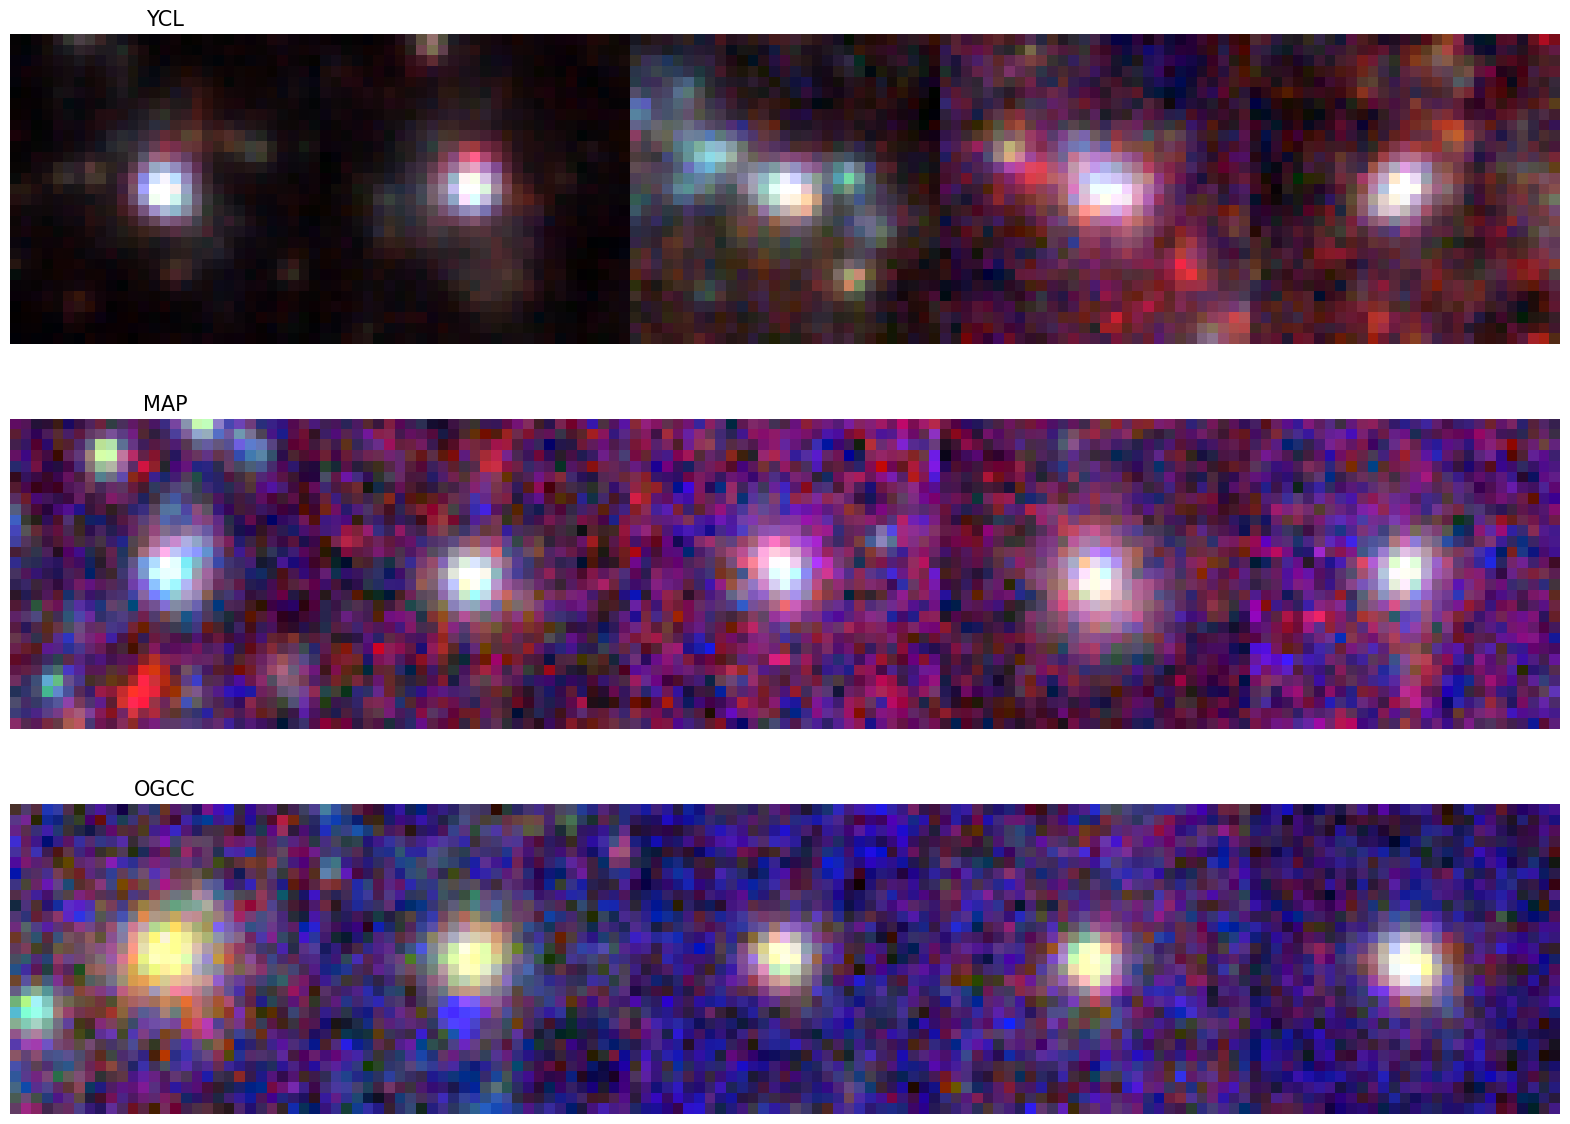

In [21]:
def download_sundog_cutout(ra, dec, n_pix=29):
  # function to download a cutout of an rgb image in sundog
  # create URL
  npixstr = str(n_pix)
  url = ('https://archive.stsci.edu/cgi-bin/hla/' +
         'fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F' +
         bundle_file_name + '%2Fhlsp_phangs-hst_hst_wfc3-uvis_' +
         bundle_file_name + '_f814w_v1_exp-drc-sci.fits&green=%2' +
         'Fhlsps%2Fphangs-hst%2F'+bundle_file_name +
         '%2Fhlsp_phangs-hst_hst_wfc3-uvis_' + bundle_file_name +
         '_f555w_v1_exp-drc-sci.fits&blue=%2Fhlsps%2Fphangs-hst%2F' +
         bundle_file_name + '%2Fhlsp_phangs-hst_hst_wfc3-uvis_' +
         bundle_file_name + '_f438w_v1_exp-drc-sci.fits&align=1&reference' +
         '=%2Fhlsps%2Fphangs-hst%2F' + bundle_file_name +
         '%2Fhlsp_phangs-hst_hst_wfc3-uvis_' + bundle_file_name +
         '_f275w_v1_exp-drc-sci.fits&tile=&download=1&format=png&ra=' +
         str(ra) + '&dec=' + str(dec) + '&corner=0&size=' + npixstr + '&zoom=1')
  # download file
  http = PoolManager()
  with http.request('GET', url, preload_content=False) as response:
    content_length = response.info()['Content-Length']
    with open('sundog_subimage.png', 'wb') as f:
      for chunk in response.stream(32768):
        f.write(chunk)
  return  plt.imread('sundog_subimage.png')


n_rows = 3
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 15))

row_count = 0
col_count = 0

for index_row, color_class in zip(range(n_rows), ['ycl', 'map', 'ogcc']):
  mask_color_class = color_color_class_hum_cl12 == color_class
  ax[index_row, 0]. set_title(color_class.upper(), fontsize=15)
  for index_col in range(n_cols):
    img_data = download_sundog_cutout(
        ra=ra_hum_cl12[mask_color_class][index_col],
        dec=dec_hum_cl12[mask_color_class][index_col])
    ax[index_row, index_col].imshow(img_data, cmap='Greys', origin='lower')
    ax[index_row, index_col].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
